# Credit Card Lead Prediction

In [1]:
# Importing required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
import pylab
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier

In [2]:
# Loading datasets

train=pd.read_csv('../input/jobathon-data/Data/train_s3TEQDk.csv')
test=pd.read_csv('../input/jobathon-data/Data/test_mSzZ8RL.csv')

In [3]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [4]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


## Handling Missing Values

In [5]:
train.isnull().sum(), test.isnull().sum()

(ID                         0
 Gender                     0
 Age                        0
 Region_Code                0
 Occupation                 0
 Channel_Code               0
 Vintage                    0
 Credit_Product         29325
 Avg_Account_Balance        0
 Is_Active                  0
 Is_Lead                    0
 dtype: int64,
 ID                         0
 Gender                     0
 Age                        0
 Region_Code                0
 Occupation                 0
 Channel_Code               0
 Vintage                    0
 Credit_Product         12522
 Avg_Account_Balance        0
 Is_Active                  0
 dtype: int64)

In [6]:
train['Credit_Product'].value_counts()

No     144357
Yes     72043
Name: Credit_Product, dtype: int64

In [7]:
train['Credit_Product'].fillna('Yes', inplace = True)
test['Credit_Product'].fillna('Yes', inplace = True)

## Feature Engineering

In [8]:
train.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

In [9]:
# Using LabelEncoder to transform categorical features into numerical features

le = LabelEncoder()
catg_var = ['Gender', 'Occupation','Channel_Code','Credit_Product','Is_Active']
for i in catg_var:
    train[i] = le.fit_transform(train[i])
    test[i] = le.fit_transform(test[i])

In [10]:
# One Hot Encoding 'Region_Code'

list_rc=list(train.Region_Code.value_counts().index)
for i in list_rc:
    train[i]=np.where(train['Region_Code']==i, 1,0)
    test[i]=np.where(test['Region_Code']==i, 1,0)
train.drop('Region_Code', axis = 1, inplace = True)
test.drop('Region_Code', axis = 1, inplace = True)

In [11]:
train.head()

,ID,Gender,Age,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,...,RG250,RG255,RG258,RG253,RG278,RG262,RG266,RG265,RG271,RG267
0,NNVBBKZB,0,73,1,2,43,0,1045696,0,0,...,0,0,0,0,0,0,0,0,0,0
1,IDD62UNG,0,30,2,0,32,0,581988,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HD3DSEMC,0,56,3,2,26,0,1484315,1,0,...,0,0,0,0,0,0,0,0,0,0
3,BF3NC7KV,1,34,2,0,19,0,470454,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TEASRWXV,0,30,2,0,33,0,886787,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Q-Q Plot
To check the distribution and perform operations accordingly

In [12]:
def plot_data(df, feature):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.distplot(df[feature])
    plt.subplot(1,2,2)
    stat.probplot(df[feature], dist='norm', plot=pylab)
    plt.show()
    print(df[feature].skew())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


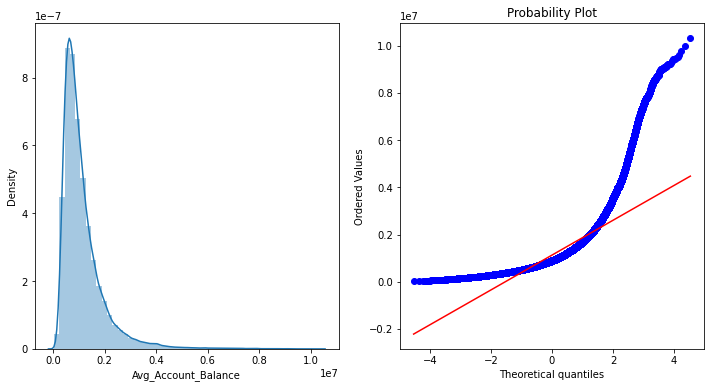

2.968726515557337


In [13]:
plot_data(train, 'Avg_Account_Balance')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


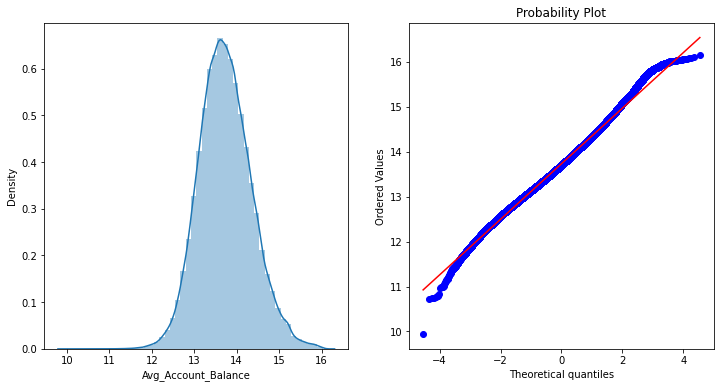

0.2351775282236966


In [14]:
train['Avg_Account_Balance']=np.log(train.Avg_Account_Balance)
test['Avg_Account_Balance']=np.log(test.Avg_Account_Balance)
plot_data(train, 'Avg_Account_Balance')

## Splitting dataset and performing oversampling

In [15]:
X = train.drop(['ID','Is_Lead'], axis = 1)
y = train.Is_Lead

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33)

In [16]:
# Changing dtypes
train['Avg_Account_Balance'] = train['Avg_Account_Balance'].astype(int)
test['Avg_Account_Balance'] = test['Avg_Account_Balance'].astype(int)

In [17]:
# Performing Oversampling

ros=RandomOverSampler(0.75)
X_resampled,y_resampled = ros.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_resampled)))

/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.75 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


The number of classes before fit Counter({0: 125839, 1: 38796})
The number of classes after fit Counter({0: 125839, 1: 94379})


## Model build and training

In [18]:
# XGBoost

xgb = XGBClassifier(use_label_encoder=False, max_depth=3, n_estimators=500, learning_rate=0.05).fit(X_resampled, y_resampled)
pred_y_xgb = xgb.predict(X_test)
accuracy = roc_auc_score(y_test, pred_y_xgb)
accuracy

[07:13:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0.7850922248449025

In [19]:
#LGBMClassifier

clf = LGBMClassifier(n_estimators=500, learning_rate=0.05)
clf.fit(X_resampled, y_resampled)
pred_y_lgbm = clf.predict(X_test)

lgbm_accuracy = roc_auc_score(y_test, pred_y_lgbm)
lgbm_accuracy

0.7822689128301201

## Final prediction and submission

In [20]:
predictions = xgb.predict(test.drop('ID', axis = 1))
submission = pd.DataFrame({'ID': test['ID'],
                    'Is_Lead': predictions})

submission.to_csv("submission.csv", index=False)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
